In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [12]:
# nifty50_stocks = [
#     "RELIANCE.NS" , "TCS.NS", "HDFCBANK.NS",  # ... Add other stock symbols here
#     # List of all NIFTY50 stocks: https://www1.nseindia.com/live_market/dynaContent/live_watch/equities_stock_watch.htm
# ]

start_date = "2010-01-01"
end_date = "2019-06-30"

stock_data = pd.DataFrame()

stock_data = yf.download("RELIANCE.NS", start=start_date, end=end_date)
stock_data.to_csv('reliance_stock_data.csv', index=False)

print("Data collection and saving complete.")

[*********************100%%**********************]  1 of 1 completed
Data collection and saving complete.


In [2]:
# Read the data from the csv file, read only the column named Close
stock_data = pd.read_csv("reliance_stock_data.csv")[["Close"]]
stock_data.head()

,Close
0,532.700500
1,530.323059
2,538.891846
3,547.832092
4,546.395691


In [3]:
stock_data.describe()

,Close
count,2339.000000
mean,586.935741
std,255.480789
min,334.875702
25%,427.250092
50%,489.683289
75%,555.992249
max,1395.620850


In [4]:
# Divide into 90% training and 10% testing
training_stock_data = stock_data[:int(len(stock_data)*0.9)].values
testing_stock_data = stock_data[int(len(stock_data)*0.9):].values

len(training_stock_data), len(testing_stock_data)

(2105, 234)

In [5]:
min(training_stock_data), max(training_stock_data)

(array([334.8757019]), array([1029.0456543]))

In [6]:
min(testing_stock_data), max(testing_stock_data)

(array([1021.12078857]), array([1395.62084961]))

Clearly this shows, the stock value has an upward ascent<br>
Hence, we cannot have states as sections in range of training data's stock values as when it comes to testing, it will see newer values again.
Its better to work on the difference, or log ratios of consecutive occurences.<br>
<ul>
<li>Method 1: Differential States</li>
<li>Method 2: Log Returns</li>
</ul>


In [7]:
differential_training_stock_data = training_stock_data[1:] - training_stock_data[:-1]
len(differential_training_stock_data)

2104

In [8]:
min(differential_training_stock_data), max(differential_training_stock_data)

(array([-39.12908936]), array([59.08990479]))

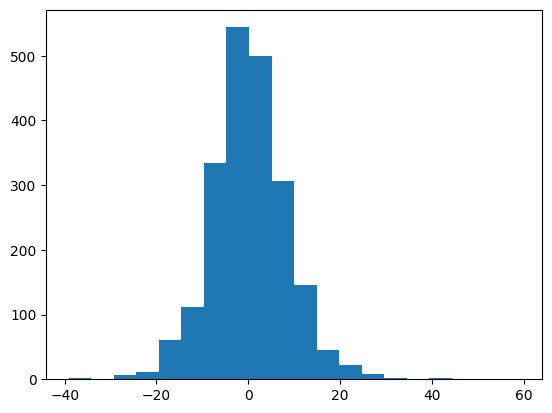

In [9]:
# Plot histogram of differential_training_stock_data
plt.hist(differential_training_stock_data, bins=20)
plt.show()

In [10]:
# Print the bins for histogram of a data
hist, bins = np.histogram(differential_training_stock_data, bins=20)
# Print the histogram plot
print(bins)

[-39.12908936 -34.21813965 -29.30718994 -24.39624023 -19.48529053
 -14.57434082  -9.66339111  -4.75244141   0.1585083    5.06945801
   9.98040771  14.89135742  19.80230713  24.71325684  29.62420654
  34.53515625  39.44610596  44.35705566  49.26800537  54.17895508
  59.08990479]


In [11]:
differential_testing_stock_data = testing_stock_data[1:] - testing_stock_data[:-1]
len(differential_testing_stock_data), min(differential_testing_stock_data), max(differential_testing_stock_data)

(233, array([-82.07214355]), array([59.98144531]))

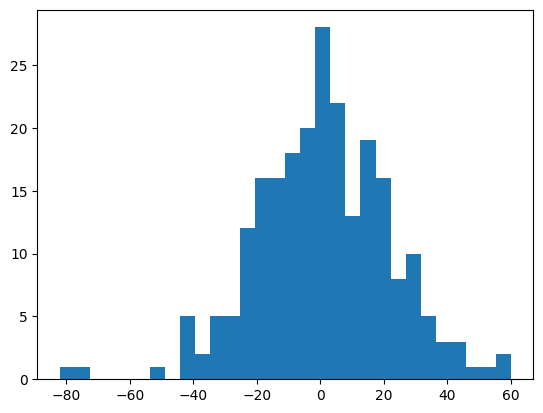

In [12]:
plt.hist(differential_testing_stock_data, bins=30)
plt.show()

### Q Learning Temporal Difference Agent

In [36]:
from tqdm import tqdm

class Q_Learning_Agent:
    def __init__(self, bins, principal = 1000000, num_iterations=200, checkpoint=10):

        self.num_iterations = num_iterations
        self.checkpoint = checkpoint

        # Values below are hyperparameters
        # These are the values that we will tune to get the best results
        self.epsilon = 0.9
        self.decay = 0.999
        self.gamma = 0.9
        self.alpha = 0.9

        # Values below are the environment values
        self.max_lots_tradable = 36
        self.lot_size = 50
        self.transaction_cost = 0.000007

        self.bins = bins        

        # Values below are the state and action spaces and the q-table
        self.action_space = [i for i in range(-self.max_lots_tradable, self.max_lots_tradable+1)]
        print(self.action_space)
        # self.state_space = [i for i in range(-self.max_lots_cumulative_traded, self.max_lots_cumulative_traded+1)]
        self.q_table = np.zeros((len(self.bins)+1, len(self.action_space)))

        # Values below are the current state of the agent
        self.cumulative_reward = 0
        self.money = principal
        self.principal = principal
    
    def map_diff_2_statespace(self, diff):
        return np.digitize(x=diff, bins=self.bins)[0]
    
    # Epsilon Greedy Approach ==> (Can we do better? Thomson Sampling? or UCB?)
    def get_action(self, current_val):
        if np.random.uniform(0,1) <= self.epsilon:
            action = np.random.choice(self.action_space)
            self.epsilon = self.epsilon * self.decay
            assert(action in self.action_space)
            return action
        else:
            current_state = self.map_diff_2_statespace(current_val)
            action = np.argmax(self.q_table[current_state]) - self.max_lots_tradable
            assert(action in self.action_space)
            return action
    
    def get_reward(self, current_val, action):
        earlier_money = self.money
        self.money += action*self.lot_size*current_val - abs(action)*self.lot_size*self.transaction_cost
        reward = self.money - earlier_money
        return reward
    
    # GREEDY APPROACH => UNSTABLE LEARNING OR 
    # Maybe Use RL-LSTM (NIPS Paper, Literature Review)
    # def predict_next_state(self):
    #     return np.argmax(self.q_table[self.current_state])

    def update_q_table(self, current_val, action, next_val):
        current_state = self.map_diff_2_statespace(current_val)
        next_state = self.map_diff_2_statespace(next_val)
        reward = self.get_reward(current_val, action)
        self.cumulative_reward += reward
        q_new = reward + self.gamma*np.max(self.q_table[next_state])
        self.q_table[current_state][action+self.max_lots_tradable] = (1-self.alpha)*self.q_table[current_state][action+self.max_lots_tradable] + self.alpha*q_new
    def train(self, data):
        cumulative_rewards = []
        for i in range(self.num_iterations):
            # print("Iteration: ", i+1)
            prev_val = data[0]
            # for val in tqdm(data[1:]):
            for val in data[1:]:
                action = self.get_action(current_val=prev_val)
                self.update_q_table(prev_val, action, val)

                prev_val = val

            if (i+1)%self.checkpoint == 0:
                print("Iteration:", i+1, " Cumulative Reward:", self.cumulative_reward)

            cumulative_rewards.append(self.cumulative_reward)
            self.cumulative_reward = 0
            self.epsilon = 0.9
            self.money = self.principal
        return cumulative_rewards

    def plot_progress(self, cumulative_rewards):
        plt.plot(cumulative_rewards)
        plt.xlabel("Iterations")
        plt.ylabel("Cumulative Reward")
        plt.show()
    
    def save_q_table(self, filename):
        np.save(filename, self.q_table)
    
    def load_q_table(self, filename):
        self.q_table = np.load(filename)

[-36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]
Iteration: 50  Cumulative Reward: [852320.78958125]
Iteration: 100  Cumulative Reward: [-133175.12687207]
Iteration: 150  Cumulative Reward: [772415.71555801]
Iteration: 200  Cumulative Reward: [532700.49348828]
Iteration: 250  Cumulative Reward: [905590.83893008]
Iteration: 300  Cumulative Reward: [825685.76490684]
Iteration: 350  Cumulative Reward: [958860.88827891]
Iteration: 400  Cumulative Reward: [-532700.50748828]
Iteration: 450  Cumulative Reward: [559335.5181627]
Iteration: 500  Cumulative Reward: [-399525.38061621]
Iteration: 550  Cumulative Reward: [-479430.45673945]
Iteration: 600  Cumulative Reward: [-612605.58361152]
Iteration: 650  Cumulative Reward: [-799050.7612324

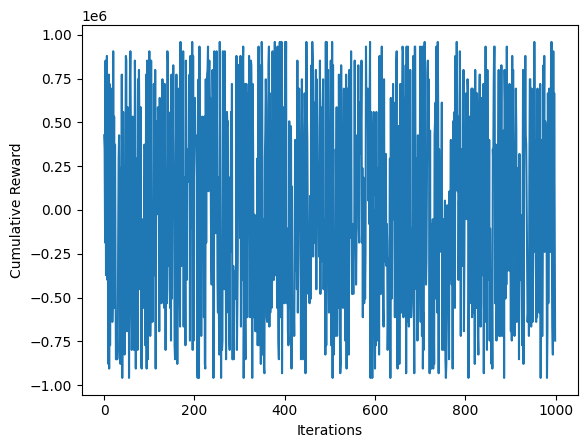

In [37]:
agent = Q_Learning_Agent(bins, principal = 1000000, num_iterations = 1000, checkpoint = 50)
cumulative_rewards = agent.train(training_stock_data)
agent.plot_progress(cumulative_rewards)

In [40]:
agent.save_q_table("q_table")

In [44]:
def test(agent, data):
        agent.money = 1000000
        cumulative_reward = 0
        agent.epsilon = 0.9
        actions, rewards = [], []
        for val in tqdm(data):
            action = np.argmax(agent.q_table[agent.map_diff_2_statespace(val)])
            actions.append(action)
            reward = agent.get_reward(action, val)
            rewards.append(reward)
            cumulative_reward += reward

        return actions, rewards, cumulative_reward


100%|██████████| 234/234 [00:00<00:00, 28700.39it/s]


In [45]:
actions, rewards, cumulative_reward = test(agent, testing_stock_data)
cumulative_reward

array([1876326.46799635])

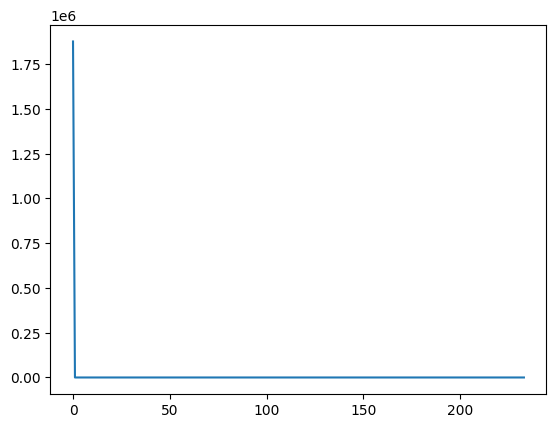

In [46]:
plt.plot(rewards)

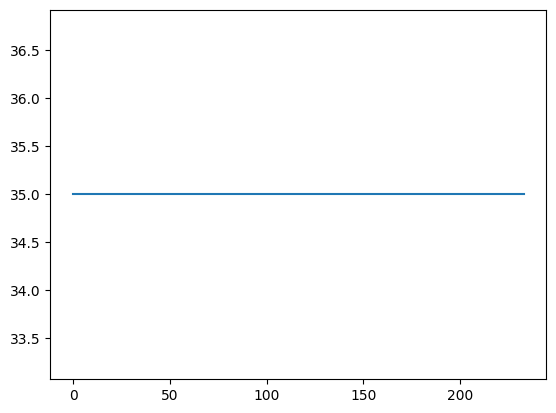

In [47]:
plt.plot(actions)